In [1]:
import pandas as pd
import networkx as nx

In [2]:
# Saccharomyces cerevisiae

string_df_4932 = pd.read_csv("organismos_string/4932_protein.txt", sep=" ")
string_df_4932

,protein1,protein2,combined_score
0,4932.Q0010,4932.YPL135W,347
1,4932.Q0010,4932.Q0017,945
2,4932.Q0010,4932.YOL103W,163
3,4932.Q0010,4932.YJR122W,528
4,4932.Q0010,4932.YGL043W,284
...,...,...,...
1988587,4932.YPR204W,4932.YPR137C-A,169
1988588,4932.YPR204W,4932.YDR316W-A,282
1988589,4932.YPR204W,4932.YDR215C,315
1988590,4932.YPR204W,4932.YAL017W,152


In [7]:
# Caenorhabditis elegans

string_df_6239 = pd.read_csv("organismos_string/6239_protein.txt", sep=" ")
string_df_6239

,protein1,protein2,combined_score
0,6239.2L52.1,6239.F44C8.3,178
1,6239.2L52.1,6239.ZC416.4,285
2,6239.2L52.1,6239.C41G7.2,189
3,6239.2L52.1,6239.C16C2.3a,191
4,6239.2L52.1,6239.C06E2.3,202
...,...,...,...
8963323,6239.cTel55X.1b,6239.ZK829.2,188
8963324,6239.cTel55X.1b,6239.Y73B6BL.28,153
8963325,6239.cTel55X.1b,6239.T20F5.2,351
8963326,6239.cTel55X.1b,6239.T25G12.5,167


In [8]:
# Danio rerio

string_df_7955 = pd.read_csv("organismos_string/7955_protein.txt", sep=" ")
string_df_7955

,protein1,protein2,combined_score
0,7955.ENSDARP00000000004,7955.ENSDARP00000018371,273
1,7955.ENSDARP00000000004,7955.ENSDARP00000124436,177
2,7955.ENSDARP00000000004,7955.ENSDARP00000024612,406
3,7955.ENSDARP00000000004,7955.ENSDARP00000032337,211
4,7955.ENSDARP00000000004,7955.ENSDARP00000024204,154
...,...,...,...
22592423,7955.ENSDARP00000129874,7955.ENSDARP00000126396,175
22592424,7955.ENSDARP00000129874,7955.ENSDARP00000024082,321
22592425,7955.ENSDARP00000129874,7955.ENSDARP00000055384,179
22592426,7955.ENSDARP00000129874,7955.ENSDARP00000113219,454


In [9]:
# Mus Musculus

string_df_10090 = pd.read_csv("organismos_string/10090_protein.txt", sep=" ")
string_df_10090

,protein1,protein2,combined_score
0,10090.ENSMUSP00000000001,10090.ENSMUSP00000031145,161
1,10090.ENSMUSP00000000001,10090.ENSMUSP00000071486,208
2,10090.ENSMUSP00000000001,10090.ENSMUSP00000119330,183
3,10090.ENSMUSP00000000001,10090.ENSMUSP00000066449,259
4,10090.ENSMUSP00000000001,10090.ENSMUSP00000061539,229
...,...,...,...
14496353,10090.ENSMUSP00000141183,10090.ENSMUSP00000130793,150
14496354,10090.ENSMUSP00000141183,10090.ENSMUSP00000135905,150
14496355,10090.ENSMUSP00000141183,10090.ENSMUSP00000139505,248
14496356,10090.ENSMUSP00000141183,10090.ENSMUSP00000048340,211


In [10]:
# Drosophila melanogaster

string_df_7227 = pd.read_csv("organismos_string/7227_protein.txt", sep=" ")
string_df_7227

,protein1,protein2,combined_score
0,7227.FBpp0070001,7227.FBpp0293850,150
1,7227.FBpp0070001,7227.FBpp0087873,152
2,7227.FBpp0070001,7227.FBpp0079990,167
3,7227.FBpp0070001,7227.FBpp0080090,298
4,7227.FBpp0070001,7227.FBpp0075453,446
...,...,...,...
4343793,7227.FBpp0306233,7227.FBpp0080342,334
4343794,7227.FBpp0306233,7227.FBpp0080913,595
4343795,7227.FBpp0306233,7227.FBpp0080607,676
4343796,7227.FBpp0306233,7227.FBpp0081073,783


In [11]:
# Schistossoma Mansoni

string_df_6183 = pd.read_csv("organismos_string/6183_protein.txt", sep=" ")
string_df_6183

,protein1,protein2,combined_score
0,6183.Smp_000020.1,6183.Smp_128600.1,173
1,6183.Smp_000020.1,6183.Smp_128770.1,258
2,6183.Smp_000020.1,6183.Smp_153590.1,154
3,6183.Smp_000020.1,6183.Smp_009990.1,238
4,6183.Smp_000020.1,6183.Smp_106080.1,296
...,...,...,...
3204857,6183.Smp_900110.1,6183.Smp_033610.1,991
3204858,6183.Smp_900110.1,6183.Smp_038330.1,393
3204859,6183.Smp_900110.1,6183.Smp_039000.1,332
3204860,6183.Smp_900110.1,6183.Smp_166680.1,327


## Funções dos grafos

In [3]:
protein_interaction_df = string_df_4932

In [4]:
# Enumerando as proteínas da Cerevisiae

protein_map = { v:k for k, v in enumerate(set(protein_interaction_df.loc[:, "protein1"]).union(
    set(protein_interaction_df.loc[:, "protein2"]))) }


print(len(protein_map))

6394


In [5]:
protein_map

{'4932.YKL063C': 0,
 '4932.YBR111C': 1,
 '4932.YDR075W': 2,
 '4932.YNL212W': 3,
 '4932.YNL326C': 4,
 '4932.YLR429W': 5,
 '4932.YGR251W': 6,
 '4932.YLR193C': 7,
 '4932.YGL104C': 8,
 '4932.YOL163W': 9,
 '4932.YJR024C': 10,
 '4932.YBL016W': 11,
 '4932.YPR021C': 12,
 '4932.YBL035C': 13,
 '4932.YIL104C': 14,
 '4932.YIL112W': 15,
 '4932.YNL182C': 16,
 '4932.YKL077W': 17,
 '4932.YLR369W': 18,
 '4932.YOR152C': 19,
 '4932.YGR020C': 20,
 '4932.YOR352W': 21,
 '4932.YAL056C-A': 22,
 '4932.YHR132C': 23,
 '4932.YLR157C': 24,
 '4932.YER082C': 25,
 '4932.YJL222W-A': 26,
 '4932.YKL003C': 27,
 '4932.YOR321W': 28,
 '4932.YJR002W': 29,
 '4932.YCR028C': 30,
 '4932.YDL132W': 31,
 '4932.YBL097W': 32,
 '4932.YNL160W': 33,
 '4932.YOR132W': 34,
 '4932.YPL264C': 35,
 '4932.YGR138C': 36,
 '4932.YBR150C': 37,
 '4932.YJR067C': 38,
 '4932.YNL055C': 39,
 '4932.YNL036W': 40,
 '4932.YJL165C': 41,
 '4932.YAR030C': 42,
 '4932.YER132C': 43,
 '4932.YHL004W': 44,
 '4932.YNL156C': 45,
 '4932.YML051W': 46,
 '4932.YLR149C-A': 

In [6]:
# Mapeando as proteínas para gerar o grafo

def mapProtein(protein_interaction_df, protein_map):
    
    protein_interation_masked = pd.DataFrame()
    
    proteins = ['protein1', 'protein2']
    
    for p in proteins:
        protein_interation_masked[p] = protein_interaction_df[p].map(protein_map)
    
    return protein_interation_masked

In [7]:
protein_interation_masked = mapProtein(protein_interaction_df, protein_map)
protein_interation_masked

,protein1,protein2
0,5797,2415
1,5797,4931
2,5797,4560
3,5797,1484
4,5797,931
...,...,...
1988587,3333,1782
1988588,3333,2608
1988589,3333,912
1988590,3333,5954


In [8]:
def generateGraph(protein_interation_masked):

    # Gerar grafo a partir do mapeamento do dataframe do Pandas
    protein_interaction_graph = nx.from_pandas_edgelist(
        protein_interation_masked, 
        source = "protein1", 
        target = "protein2"
    )
    
    return protein_interaction_graph

In [9]:
def generateDF(protein_interaction_graph):
    return nx.to_pandas_edgelist(protein_interaction_graph)

In [10]:
# Geração do grafo de PPI

graph = generateGraph(protein_interation_masked)
df_graph = generateDF(graph)
df_graph

,source,target
0,5797,2415
1,5797,4931
2,5797,4560
3,5797,1484
4,5797,931
...,...,...
994291,3818,1643
994292,3554,2804
994293,1214,5564
994294,4892,1127


In [11]:
# Medidas de Centralidade
import time

seconds_ini = time.time()

# Degree Centrality
degree = nx.degree_centrality(graph)

In [12]:
# Eigenvector Centrality
eigenvector = nx.eigenvector_centrality(graph)

In [13]:
# Betweenness Centrality
betweenness = nx.betweenness_centrality(graph)

In [14]:
# Closeness Centrality
closeness = nx.closeness_centrality(graph)

In [15]:
# Clustering
clustering = nx.clustering(graph)

In [16]:
# Pagerank
pagerank = nx.pagerank(graph)

seconds_fini = time.time()

print("Seconds since epoch =", seconds_fini - seconds_ini)

NameError: name 'seconds_fini' is not defined

In [17]:
# Criando um Dataframe
from collections import OrderedDict

degree_ordered = OrderedDict(sorted(degree.items()))
eigenvector_ordered = OrderedDict(sorted(eigenvector.items()))
betweenness_ordered = OrderedDict(sorted(betweenness.items()))
closeness_ordered = OrderedDict(sorted(closeness.items()))
clustering_ordered = OrderedDict(sorted(clustering.items()))
pagerank_ordered = OrderedDict(sorted(pagerank.items()))


protein_features = pd.concat([pd.Series(list(protein_map.keys())),
                              pd.Series(list(degree_ordered.values())), 
                              pd.Series(list(eigenvector_ordered.values())),
                              pd.Series(list(betweenness_ordered.values())), 
                              pd.Series(list(closeness_ordered.values())),
                              pd.Series(list(clustering_ordered.values())),
                              pd.Series(list(pagerank_ordered.values()))], axis=1)

protein_features.columns = ["Protein_key",
                            "DegreeCentrality",
                            "EigenvectorCentrality",
                            "BetweennessCentrality",
                            "ClosenessCentrality",
                            "Clustering",
                            "Pagerank"]
                           

In [18]:
protein_features

,Protein_key,DegreeCentrality,EigenvectorCentrality,BetweennessCentrality,ClosenessCentrality,Clustering,Pagerank
0,4932.YKL063C,0.002033,2.899063e-04,2.419058e-07,0.428571,0.217949,0.000029
1,4932.YBR111C,0.076959,1.930977e-02,2.129255e-04,0.504339,0.371583,0.000213
2,4932.YDR075W,0.117472,1.987889e-02,5.517442e-04,0.518281,0.226170,0.000338
3,4932.YNL212W,0.019553,2.743433e-03,3.605881e-05,0.477696,0.176774,0.000083
4,4932.YNL326C,0.023463,2.957144e-03,5.297553e-05,0.476414,0.195526,0.000095
...,...,...,...,...,...,...,...
6389,4932.YPR130C,0.000313,1.423185e-07,0.000000e+00,0.258460,1.000000,0.000034
6390,4932.YDR292C,0.123103,2.698482e-02,4.165287e-04,0.519925,0.287845,0.000332
6391,4932.YBR248C,0.069138,1.244945e-02,1.256345e-04,0.500313,0.268230,0.000202
6392,4932.YLR212C,0.210856,2.829638e-02,5.028229e-03,0.548661,0.105751,0.000663


In [20]:
# Rotulando as proteínas essencias

dataset_essential = pd.read_csv('essential_genes.csv')

In [21]:
sac_proteins = list(dataset_essential[dataset_essential['Code_Organism'] == 'DEG2001']['Locus'])

protein_features['is_essential'] = protein_features.apply(lambda x: 1 if x.Protein_key in sac_proteins 
                                                          else 0, axis=1)

In [22]:
protein_features

,Protein_key,DegreeCentrality,EigenvectorCentrality,BetweennessCentrality,ClosenessCentrality,Clustering,Pagerank,is_essential
0,4932.YKL063C,0.002033,2.899063e-04,2.419058e-07,0.428571,0.217949,0.000029,0
1,4932.YBR111C,0.076959,1.930977e-02,2.129255e-04,0.504339,0.371583,0.000213,0
2,4932.YDR075W,0.117472,1.987889e-02,5.517442e-04,0.518281,0.226170,0.000338,0
3,4932.YNL212W,0.019553,2.743433e-03,3.605881e-05,0.477696,0.176774,0.000083,0
4,4932.YNL326C,0.023463,2.957144e-03,5.297553e-05,0.476414,0.195526,0.000095,0
...,...,...,...,...,...,...,...,...
6389,4932.YPR130C,0.000313,1.423185e-07,0.000000e+00,0.258460,1.000000,0.000034,0
6390,4932.YDR292C,0.123103,2.698482e-02,4.165287e-04,0.519925,0.287845,0.000332,1
6391,4932.YBR248C,0.069138,1.244945e-02,1.256345e-04,0.500313,0.268230,0.000202,0
6392,4932.YLR212C,0.210856,2.829638e-02,5.028229e-03,0.548661,0.105751,0.000663,1


In [23]:
protein_features.to_csv('proteins_features.csv', index=False)

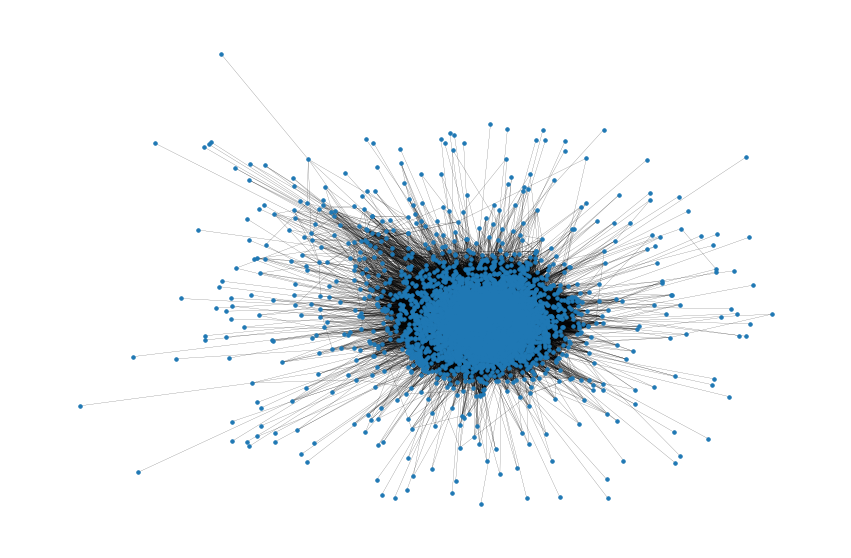

In [28]:
# Graph 

# Fonte: https://networkx.org/nx-guides/content/exploratory_notebooks/facebook_notebook.html

from random import randint
import matplotlib.pyplot as plt

pos = nx.spring_layout(graph)


plt.figure(figsize=(15,10))
plt.axis('off') 
nx.draw_networkx(graph, pos=pos, node_size=12, with_labels=False, width=0.15)

### Visualização de dados

In [24]:
df = pd.read_csv("proteins_features.csv")
df

,Protein_key,DegreeCentrality,EigenvectorCentrality,BetweennessCentrality,ClosenessCentrality,Clustering,Pagerank,is_essential
0,4932.YKL063C,0.002033,2.899063e-04,2.419058e-07,0.428571,0.217949,0.000029,0
1,4932.YBR111C,0.076959,1.930977e-02,2.129255e-04,0.504339,0.371583,0.000213,0
2,4932.YDR075W,0.117472,1.987889e-02,5.517442e-04,0.518281,0.226170,0.000338,0
3,4932.YNL212W,0.019553,2.743433e-03,3.605881e-05,0.477696,0.176774,0.000083,0
4,4932.YNL326C,0.023463,2.957144e-03,5.297553e-05,0.476414,0.195526,0.000095,0
...,...,...,...,...,...,...,...,...
6389,4932.YPR130C,0.000313,1.423185e-07,0.000000e+00,0.258460,1.000000,0.000034,0
6390,4932.YDR292C,0.123103,2.698482e-02,4.165287e-04,0.519925,0.287845,0.000332,1
6391,4932.YBR248C,0.069138,1.244945e-02,1.256345e-04,0.500313,0.268230,0.000202,0
6392,4932.YLR212C,0.210856,2.829638e-02,5.028229e-03,0.548661,0.105751,0.000663,1


In [25]:
df_essential = df[df['is_essential'] == 1]
df_essential

,Protein_key,DegreeCentrality,EigenvectorCentrality,BetweennessCentrality,ClosenessCentrality,Clustering,Pagerank,is_essential
6,4932.YGR251W,0.042390,0.010941,0.000033,0.481981,0.629493,0.000124,1
13,4932.YBL035C,0.055373,0.008291,0.000130,0.496544,0.377747,0.000178,1
14,4932.YIL104C,0.035351,0.008454,0.000018,0.478017,0.623874,0.000108,1
16,4932.YNL182C,0.122165,0.027271,0.000255,0.518618,0.321701,0.000320,1
25,4932.YER082C,0.095730,0.023077,0.000411,0.507703,0.437411,0.000261,1
...,...,...,...,...,...,...,...,...
6365,4932.YPL028W,0.088534,0.014917,0.000235,0.508430,0.264005,0.000258,1
6368,4932.YNL222W,0.042234,0.006613,0.000088,0.486974,0.256093,0.000139,1
6374,4932.YAL032C,0.069607,0.013516,0.000247,0.502121,0.278915,0.000208,1
6390,4932.YDR292C,0.123103,0.026985,0.000417,0.519925,0.287845,0.000332,1


In [26]:
df_non_essential = df[df['is_essential'] == 0]
df_non_essential

,Protein_key,DegreeCentrality,EigenvectorCentrality,BetweennessCentrality,ClosenessCentrality,Clustering,Pagerank,is_essential
0,4932.YKL063C,0.002033,2.899063e-04,2.419058e-07,0.428571,0.217949,0.000029,0
1,4932.YBR111C,0.076959,1.930977e-02,2.129255e-04,0.504339,0.371583,0.000213,0
2,4932.YDR075W,0.117472,1.987889e-02,5.517442e-04,0.518281,0.226170,0.000338,0
3,4932.YNL212W,0.019553,2.743433e-03,3.605881e-05,0.477696,0.176774,0.000083,0
4,4932.YNL326C,0.023463,2.957144e-03,5.297553e-05,0.476414,0.195526,0.000095,0
...,...,...,...,...,...,...,...,...
6387,4932.YLR160C,0.030815,2.343443e-03,1.726755e-04,0.475351,0.172382,0.000139,0
6388,4932.YJL079C,0.025027,3.106492e-03,4.657295e-05,0.477696,0.159513,0.000098,0
6389,4932.YPR130C,0.000313,1.423185e-07,0.000000e+00,0.258460,1.000000,0.000034,0
6391,4932.YBR248C,0.069138,1.244945e-02,1.256345e-04,0.500313,0.268230,0.000202,0


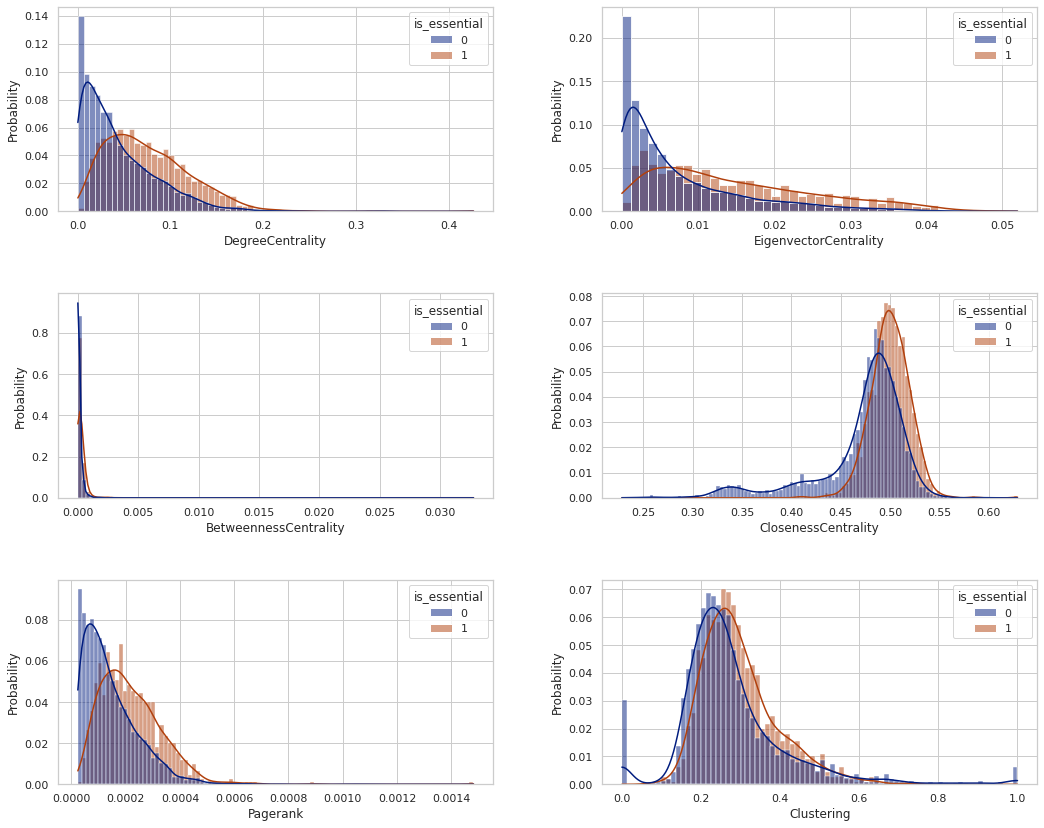

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (16,12)

# Define as configurações dos plots
# Cada plot terá o mesmo tamanho de figuras (8,10)
#plt.style.use("ggplot")

plt.figure(1)

sns.set_theme(style="whitegrid", palette="dark")


# Dados para cada subplot

plt.subplot(321)
sns.histplot(data=df, x="DegreeCentrality", hue="is_essential", 
             stat="probability", common_norm=False, kde=True)

plt.subplot(322)
sns.histplot(data=df, x="EigenvectorCentrality", hue="is_essential", 
            stat="probability", common_norm=False, kde=True)

plt.subplot(323)
sns.histplot(data=df, x="BetweennessCentrality", hue="is_essential", bins = 100,
            stat="probability", common_norm=False, kde=True)

plt.subplot(324)
sns.histplot(data=df, x="ClosenessCentrality", hue="is_essential", 
            stat="probability", common_norm=False, kde=True)

plt.subplot(325)
sns.histplot(data=df, x="Pagerank", hue="is_essential", 
            stat="probability", common_norm=False, kde=True)

plt.subplot(326)
sns.histplot(data=df, x="Clustering", hue="is_essential", 
            stat="probability", common_norm=False, kde=True)





plt.subplots_adjust(top=0.95, bottom=0.05, left=0.10, right=0.95, hspace=0.4,
                    wspace=0.25)

plt.savefig("results.jpg")
plt.show()
